In [ ]:
# Imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

# Functions

def create_sequences(X, y, sequence_length):
    X_sequences = []
    y_sequences = []
    
    for i in range(len(X) - sequence_length + 1):
        X_sequences.append(X[i:i + sequence_length])
        y_sequences.append(y[i + sequence_length - 1])
    
    return np.array(X_sequences), np.array(y_sequences)

def plot_test_versus_validation(test_losses, validation_losses, save_path=None, title=None):
    plt.plot(test_losses, label='Test Loss', color='blue')
    plt.plot(validation_losses, label='Validation Loss', color='orange')
    plt.title(title if title else 'Test vs Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

def plot_feature_over_time(data, feature):
    plt.plot(data['Date'],
             data[feature],
             label=feature,
             color='black',
             linewidth=0.8)
    plt.title(f'{feature} Over Time')
    plt.xlabel('Date')
    plt.ylabel(feature)
    plt.grid()
    
    plt.show()

def plot_boxplot_of_feature(data, feature):
    plt.boxplot(data[feature],
                vert=False,
                medianprops={'color': 'black'})
    plt.title(f'Boxplot of {feature}')
    plt.xlabel(feature)
    plt.yticks([])
    plt.grid()
    plt.show()

def convert_feature_into_cyclic(data, feature, max_value):
    data[f'{feature}_Sin'] = np.sin(2 * np.pi * data[feature] / max_value)
    data[f'{feature}_Cos'] = np.cos(2 * np.pi * data[feature] / max_value)
    return data

def preprocess(data):
    data['Date'] = pd.to_datetime(data['Date'])
    data.rename(columns={'Close/Last': 'Closing_Price'}, inplace=True)
    data['Closing_Price'] = data['Closing_Price'].str.replace('$', '').astype(float)
    data['Year'] = data['Date'].dt.year
    data['Month'] = data['Date'].dt.month
    data['Day'] = data['Date'].dt.day
    data['Weekday'] = data['Date'].dt.weekday
    print(f'Number of years: {data['Year'].max() - data['Year'].min() + 1}')
    convert_feature_into_cyclic(data, 'Year', 11)
    convert_feature_into_cyclic(data, 'Month', 12)
    convert_feature_into_cyclic(data, 'Day', 31)
    convert_feature_into_cyclic(data, 'Weekday', 7)
    data.drop(columns=['Volume', 'Open', 'High', 'Low', 'Date', 'Year', 'Month', 'Day', 'Weekday'], inplace=True)
    return data

# Read in the data

data = pd.read_csv('../csvs/apple.csv')
data = preprocess(data)
data.head()

Number of years: 11


,Closing_Price,Year_Sin,Year_Cos,Month_Sin,Month_Cos,Day_Sin,Day_Cos,Weekday_Sin,Weekday_Cos
0,238.99,0.540641,0.841254,-1.0,-1.836970e-16,-0.299363,-0.954139,0.974928,-0.222521
1,238.15,0.540641,0.841254,-1.0,-1.836970e-16,-0.101168,-0.994869,0.781831,0.623490
2,236.70,0.540641,0.841254,-1.0,-1.836970e-16,0.101168,-0.994869,0.000000,1.000000
3,234.07,0.540641,0.841254,-1.0,-1.836970e-16,0.651372,-0.758758,-0.433884,-0.900969
4,230.03,0.540641,0.841254,-1.0,-1.836970e-16,0.790776,-0.612106,0.433884,-0.900969


In [79]:
# Display some graphs

#plot_feature_over_time(data, 'Closing_Price')
#plot_boxplot_of_feature(data, 'Closing_Price')

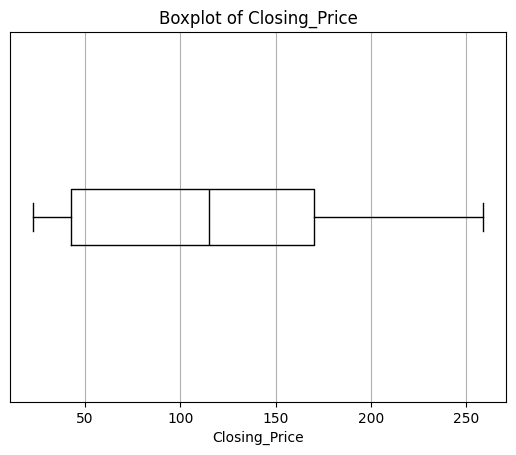

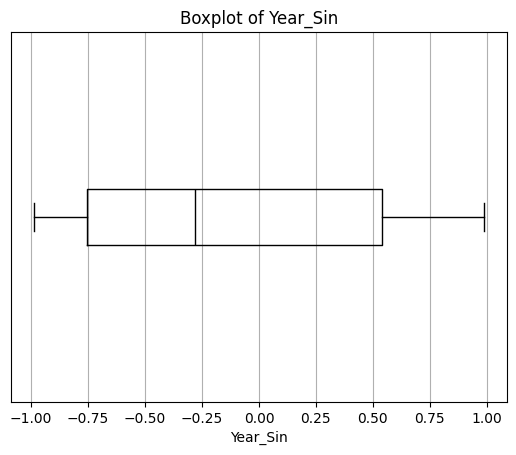

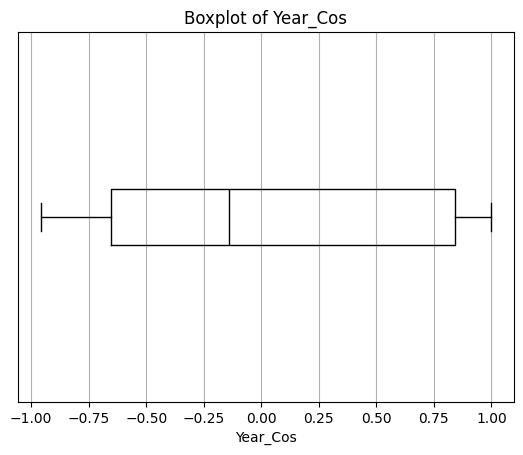

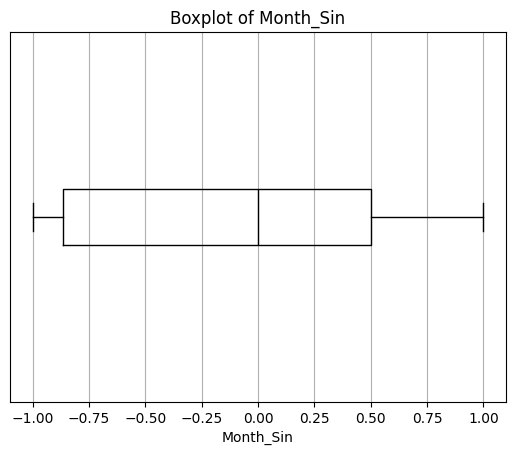

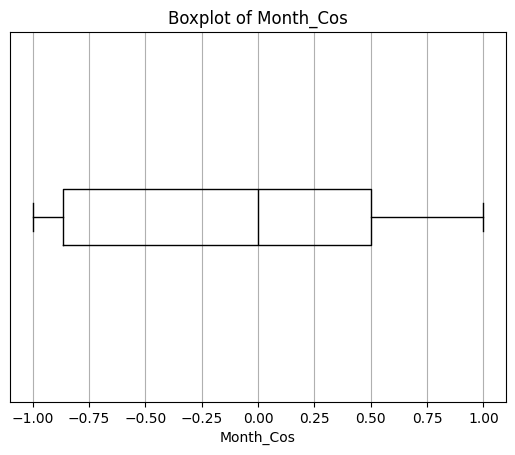

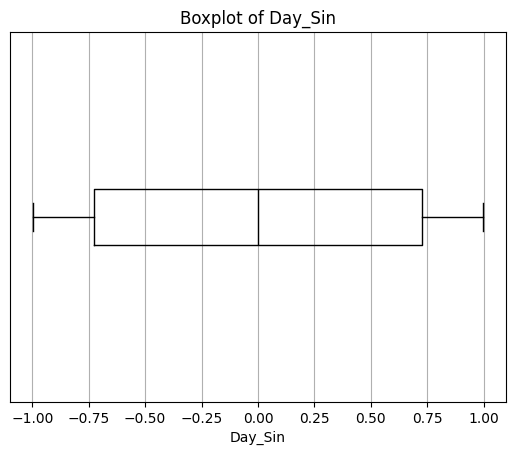

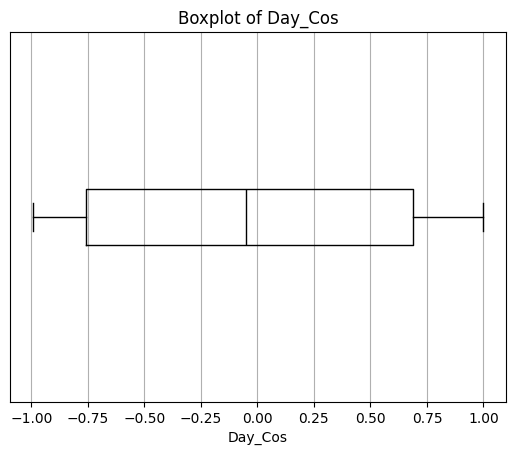

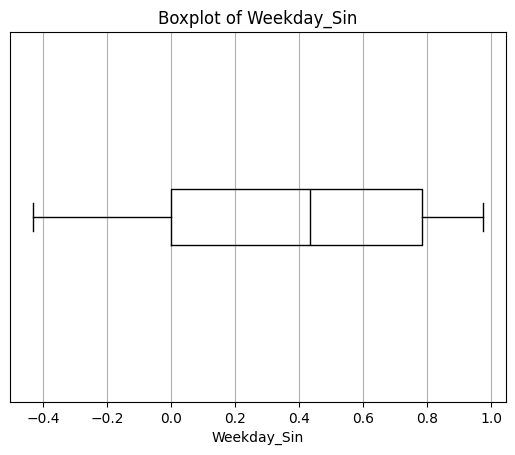

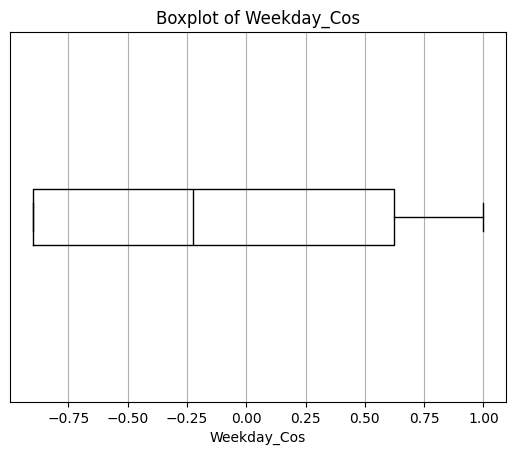

In [83]:
# Statistics of data

for feature in data.columns:
    plot_boxplot_of_feature(data, feature)


In [159]:
import torch
from torch.nn import RNN, Linear, Module, MSELoss
from torch.utils.data import DataLoader, TensorDataset
from torch import tensor, float32
from torch.optim import SGD

# Elman network

# https://docs.pytorch.org/docs/stable/generated/torch.nn.RNN.html

class ElmanRNN(Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super().__init__()
        self.rnn = RNN(input_size=input_size,
                       hidden_size=hidden_size,
                       num_layers=num_layers,
                       nonlinearity='tanh',
                       bias=True,
                       batch_first=True,
                       dropout=0.0,
                       bidirectional=False)
        self.fc = Linear(hidden_size, output_size)

    def forward(self, x):
        # All hidden states + last hidden state (h_{n-1})
        out, h_n = self.rnn(x)
        # Sequence to one task, take only last hidden state
        out = self.fc(out[:, -1, :])
        return out
    
# Prepare data for training using blocked cross validation

X = data.drop(columns=['Closing_Price']).values
y = data['Closing_Price'].values

input_shape = X.shape[1]
output_shape = 1
hidden_layer_size = 32

print(X.shape)
print(y.shape)

X_sequences, y_sequences = create_sequences(X, y, sequence_length=64)

print(X_sequences.shape)
print(y_sequences.shape)

split = TimeSeriesSplit(n_splits=8)

split_number = 1

for train_indices, validation_indices in split.split(X_sequences):
    test_losses = []
    validation_losses = []
    
    print(f'Train indices from {train_indices[0]} to {train_indices[-1]} and validation indices from {validation_indices[0]} to {validation_indices[-1]}')

    X_train, X_validation = X_sequences[train_indices], X_sequences[validation_indices]
    y_train, y_validation = y_sequences[train_indices], y_sequences[validation_indices]

    print(X_train.shape)

    # Scale data

    from sklearn.preprocessing import StandardScaler
    scaler_X = StandardScaler()
    #scaler_y = StandardScaler()
    X_train = scaler_X.fit_transform(X_train.reshape(-1, input_shape)).reshape(X_train.shape)
    #y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(-1)
    X_validation = scaler_X.transform(X_validation.reshape(-1, input_shape)).reshape(X_validation.shape)
    #y_validation = scaler_y.transform(y_validation.reshape(-1, 1)).reshape(-1)

    # Convert to tensors
    X_train_tensor = tensor(X_train, dtype=float32)
    y_train_tensor = tensor(y_train, dtype=float32).view(-1, 1)
    X_validation_tensor = tensor(X_validation, dtype=float32)
    y_validation_tensor = tensor(y_validation, dtype=float32).view(-1, 1)

    # Create datasets and dataloaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    #print(train_dataset.tensors)
    validation_dataset = TensorDataset(X_validation_tensor, y_validation_tensor)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
    validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False)

    # Initialize model, loss function, and optimizer
    model = ElmanRNN(input_shape, hidden_layer_size, output_shape)
    loss_function = MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
    num_epochs = 25

    for epoch in range(num_epochs):
        # Training of model

        model.train()
        epoch_train_loss = 0
        for i, (inputs, targets) in enumerate(train_loader):
            # Grads reset
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        # Validation of model

        model.eval()
        epoch_validation_loss = 0
        with torch.no_grad():
            for i, (inputs, targets) in enumerate(validation_loader):
                outputs = model(inputs)
                loss = loss_function(outputs, targets)
                epoch_validation_loss += loss.item()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Loss: {epoch_train_loss / len(train_loader):.4f}, '
              f'Validation Loss: {epoch_validation_loss / len(validation_loader):.4f}')
        
        test_losses.append(epoch_train_loss / len(train_loader))
        validation_losses.append(epoch_validation_loss / len(validation_loader))

    plot_test_versus_validation(test_losses,
                                validation_losses,
                                f'../images/elman_hidden32_test_vs_val_fold{split_number}.pdf',
                                title=f'Elman RNN Hidden Size 32: Fold {split_number} Test vs. Validation Performance')

    split_number += 1


(2514, 8)
(2514,)
(2451, 64, 8)
(2451,)
Train indices from 0 to 274 and validation indices from 275 to 546
(275, 64, 8)
Epoch [1/25], Loss: 48500.8917, Validation Loss: 32523.0710
Epoch [2/25], Loss: 48006.7450, Validation Loss: 31791.4265
Epoch [3/25], Loss: 46980.4796, Validation Loss: 31074.3558
Epoch [4/25], Loss: 46204.7559, Validation Loss: 30505.6023
Epoch [5/25], Loss: 45540.3566, Validation Loss: 29982.5861
Epoch [6/25], Loss: 44915.9183, Validation Loss: 29488.0335
Epoch [7/25], Loss: 44322.6980, Validation Loss: 29016.2672
Epoch [8/25], Loss: 43753.3188, Validation Loss: 28561.7435
Epoch [9/25], Loss: 43202.0930, Validation Loss: 28120.8276
Epoch [10/25], Loss: 42665.3553, Validation Loss: 27691.1173
Epoch [11/25], Loss: 42140.6573, Validation Loss: 27270.9705
Epoch [12/25], Loss: 41626.3025, Validation Loss: 26859.2130
Epoch [13/25], Loss: 41121.0585, Validation Loss: 26454.9825
Epoch [14/25], Loss: 40624.0049, Validation Loss: 26057.6207
Epoch [15/25], Loss: 40134.4380, Va

TypeError: plot_test_versus_validation() got an unexpected keyword argument 'title'